## Configure

In [1]:
from pathlib import Path
from notebook_setup import device
from torchvision import transforms
%load_ext autoreload
%autoreload 2

model_path = Path('/data/diffusion-mem/model-zoo/cifar10/subset08k/channels-128')
train_path = Path('/data/diffusion-mem/datasets/cifar10/')
sample_path = model_path / 'artifacts/samples'
ckpt_path = model_path / 'artifacts/lightning_logs/version_0/checkpoints/last.ckpt'

unet_arch = {
    'sample_size': 32,
    'in_channels': 3,
    'out_channels': 3,
    'layers_per_block': 3,
    'block_out_channels': [128, 256, 256, 256],
    'down_block_types': ['DownBlock2D', 'DownBlock2D', 'AttnDownBlock2D', 'AttnDownBlock2D'],
    'up_block_types': ['AttnUpBlock2D', 'AttnUpBlock2D', 'UpBlock2D', 'UpBlock2D']
}

data_transform = transforms.Compose([
    transforms.Resize(size=(32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
reverse_transform = transforms.Compose([
    transforms.Normalize(mean=[-1, -1, -1], std=[2, 2, 2]),
    lambda x: torch.clamp(x, min=0, max=1),
    transforms.ToPILImage(),
])

/home/brendan/anaconda3/envs/dgm-geo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading the Model

In [2]:
from models.diffusions.training import LightningDiffusion
from models.diffusions.sdes import VpSde
from models.diffusions.networks import UNet2D


unet = UNet2D(**unet_arch)
sde = VpSde(unet)
model = LightningDiffusion.load_from_checkpoint(ckpt_path, sde=sde)

## Loading the Model's Generated Samples

In [3]:
from datasets import load_dataset

gen_dataset = load_dataset(str(sample_path))

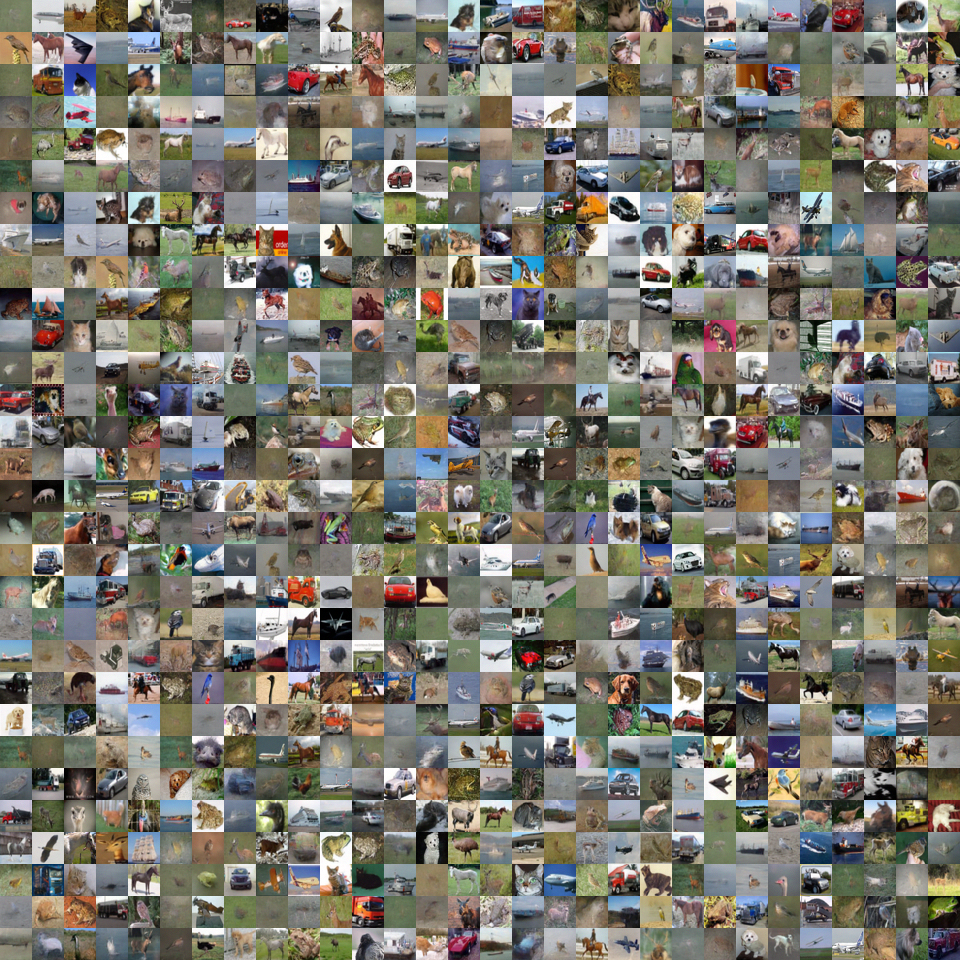

In [4]:
from PIL import Image


def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


rows, cols = 30, 30
image_grid(gen_dataset['train'][:rows*cols]['image'], rows=rows, cols=cols)

## Locating Memorized Samples

In [5]:
import pandas as pd
from mem.metrics import SSCDSimMetric
from mem.metrics.utils import get_image_dataset_in_dir

sim_estimator = SSCDSimMetric()
train_img_paths, _ = get_image_dataset_in_dir(train_path)
sample_img_paths, _ = get_image_dataset_in_dir(sample_path)
sim_estimator.build_reference_database(train_img_paths)
results = sim_estimator.get_ranked_distances(sample_img_paths)

df = pd.DataFrame.from_dict(
    {gen_sample: (distance, match) for (gen_sample, (distance, match)) in results},
    orient='index',
    columns=['distance', 'match'])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:34<00:00,  1.74it/s]


"Most memorized" generated images and their matched samples from the training set

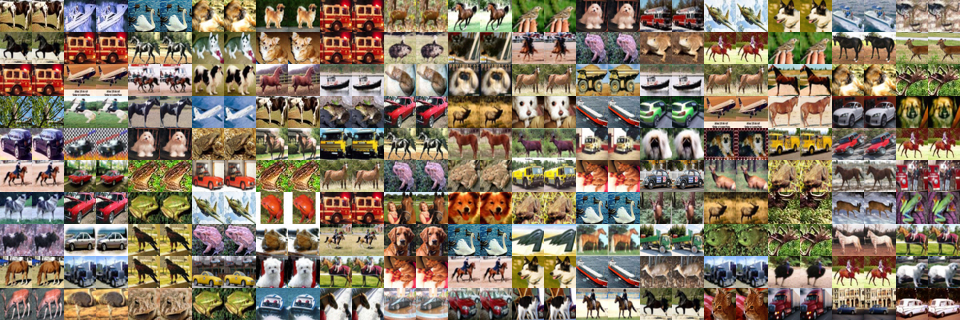

In [6]:
rows, cols = 10, 30
mem_imgs = [Image.open(path) for i in range(rows*cols//2)
         for path in (df.index[i], df.iloc[i]['match'])]
image_grid(mem_imgs, rows=rows, cols=cols)

"Least memorized" generated images and their matched samples from the training set

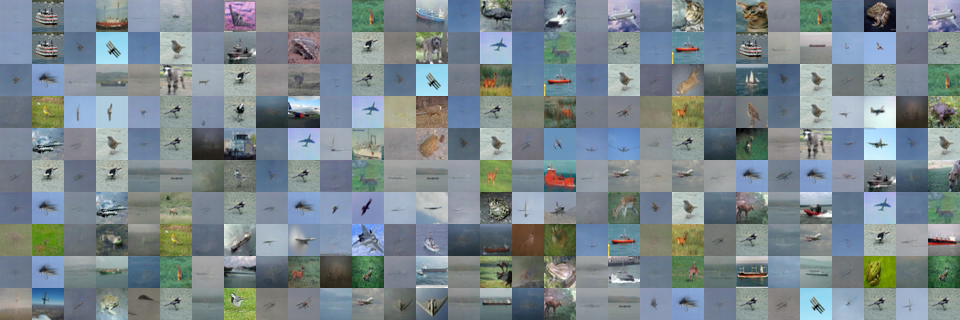

In [7]:
rows, cols = 10, 30
non_mem_imgs = [Image.open(path) for i in range(1, rows*cols//2+1) 
         for path in (df.index[-i], df.iloc[-i]['match'])]
image_grid(non_mem_imgs, rows=rows, cols=cols)

## Analysis

### Reconstruction

Reconstruct some memorized and non-memorized samples

In [8]:
import torch

dataset_tensor = torch.stack([data_transform(Image.open(path)) for path in df.index])
datapoints = torch.cat((dataset_tensor[:5], dataset_tensor[-6:-1]))
noise_levels = torch.tensor([1e-3, 1e-2, 1e-1, 2e-1, 3e-1, 4e-1, 5e-1, 6e-1, 7e-1])

input_repeated = torch.cat(
    [x.repeat(len(noise_levels), 1, 1, 1) for x in datapoints])
noise_levels_repeated = noise_levels.repeat(len(datapoints))

ims_noised = sde.solve_forward_sde(
    input_repeated.to(device), 
    t_end=noise_levels_repeated.to(device)).cpu()

ims_recon = sde.solve_reverse_sde(
    ims_noised.to(device),
    t_start=noise_levels_repeated.to(device)).cpu()

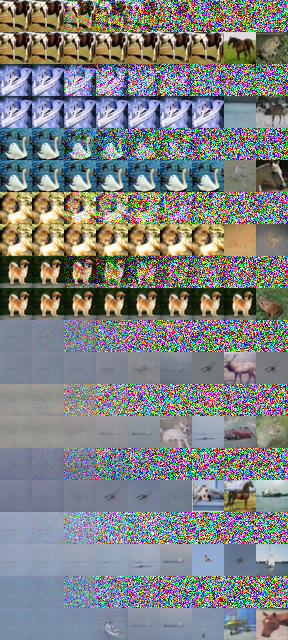

In [9]:
ims_display = torch.cat(
    (ims_noised.cpu().reshape(len(datapoints), -1, *ims_noised.shape[1:]),
     ims_recon.reshape(len(datapoints), -1, *ims_recon.shape[1:])),
    dim=1
).flatten(end_dim=1)

image_grid([reverse_transform(im) for im in ims_display], rows=2*len(datapoints), cols=len(noise_levels))

### Intrinsic Dimension

In [10]:
import torch

gen_points = torch.stack([data_transform(Image.open(path)) for path in df.index])
train_points = torch.stack([data_transform(Image.open(path)) for path in df['match']])

In [11]:
# Get a subsample of 1000 generated points to compute LIDs on
random_gen = torch.Generator()
random_gen.manual_seed(0)
subsample_ids, _ = torch.randint(0, len(gen_points), (100,), generator=random_gen).sort()

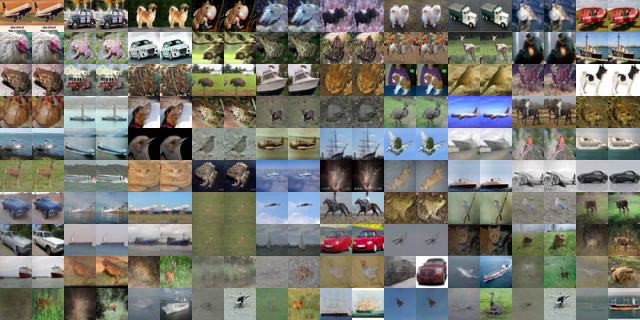

In [12]:
from einops import rearrange

display_ims = rearrange([gen_points[subsample_ids], train_points[subsample_ids]], 'a b ... -> (b a) ...')
image_grid([reverse_transform(im) for im in display_ims], rows=10, cols=20)

Compute score matrices

In [15]:
from lid.diffusions import NormalBundleEstimator

lid_estimator = NormalBundleEstimator(ambient_dim=3072, model=sde, device=device)
noise_time = 0.1
batch_size = 2048

gen_svs = lid_estimator.preprocess(
    gen_points[subsample_ids],
    noise_time=noise_time,
    score_batch_size=batch_size,
).singular_values

Computing 12288 scores for 100 points: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [15:52<00:00,  9.52s/it]


In [16]:
train_svs = lid_estimator.preprocess(
    train_points[subsample_ids],
    noise_time=noise_time,
    score_batch_size=batch_size,
).singular_values

Computing 12288 scores for 100 points: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [15:54<00:00,  9.54s/it]


Check singular values of score matrix around memorized vs. unmemorized samples from the model

Text(0.5, 1.0, 'Memorized vs. Unmemorized Generated Points: Score Matrix Singular Values ($t_0 = 0.1$)')

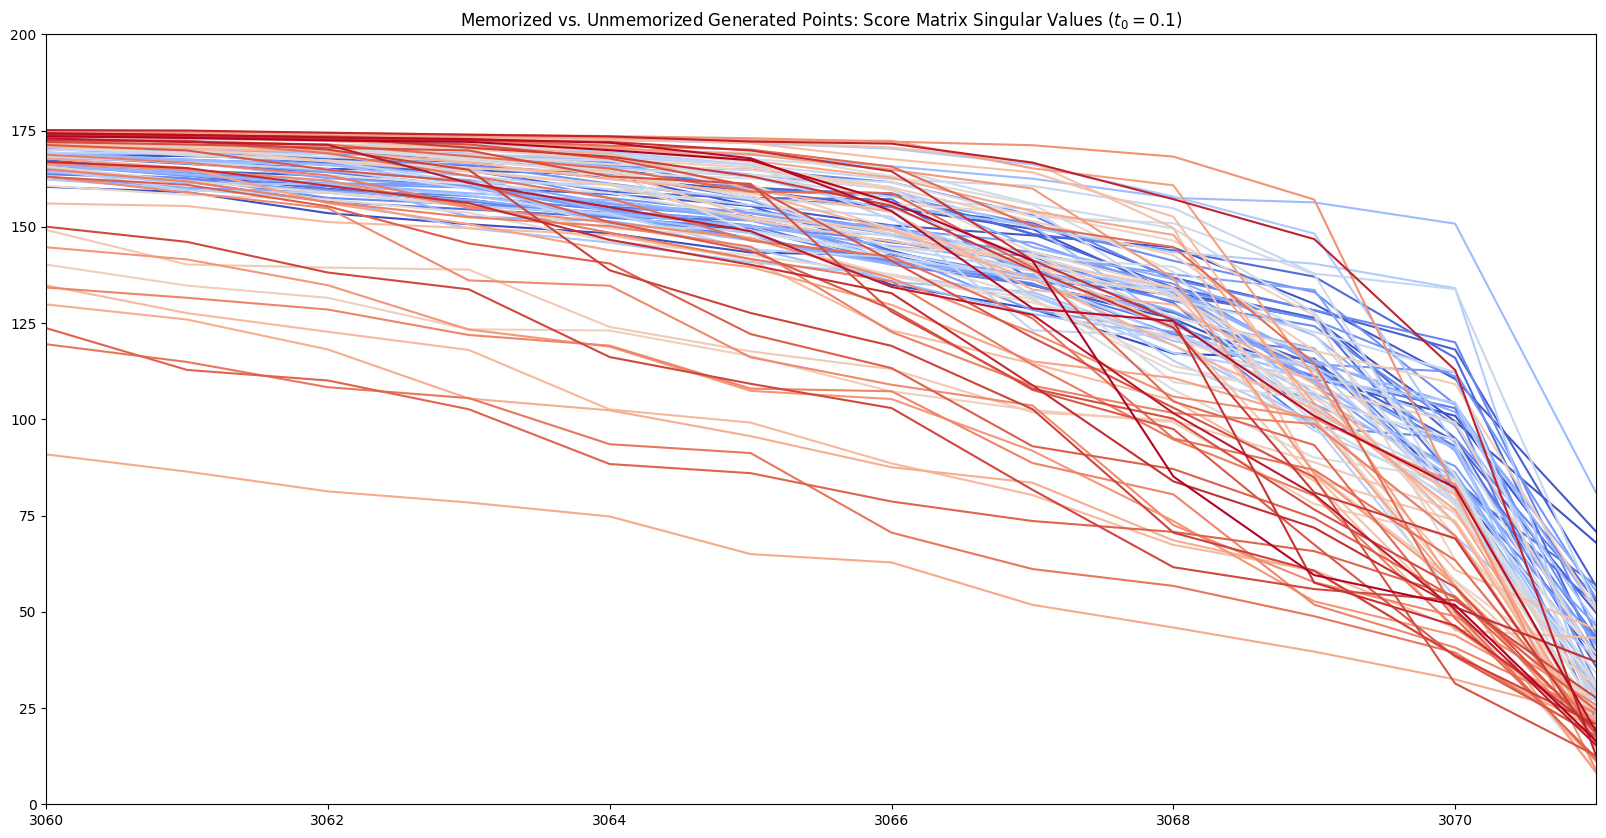

In [17]:
import matplotlib.pyplot as plt

cmap = plt.get_cmap('coolwarm')

def plot_svs(svs):
    plt.figure(figsize=(20, 10))
    
    for i, sv in enumerate(svs):
        plt.plot(sv, label=i, c=cmap(i/(len(svs)-1)))
    
    plt.xlim((3060, 3071))
    plt.ylim((0, 200))

plot_svs(gen_svs)
plt.title(f'Memorized vs. Unmemorized Generated Points: Score Matrix Singular Values ($t_0 = {noise_time}$)')

Check singular values of score matrix around memorized vs. unmemorized training points

Text(0.5, 1.0, 'Memorized vs. Unmemorized Training Points: Score Matrix Singular Values ($t_0 = 0.1$)')

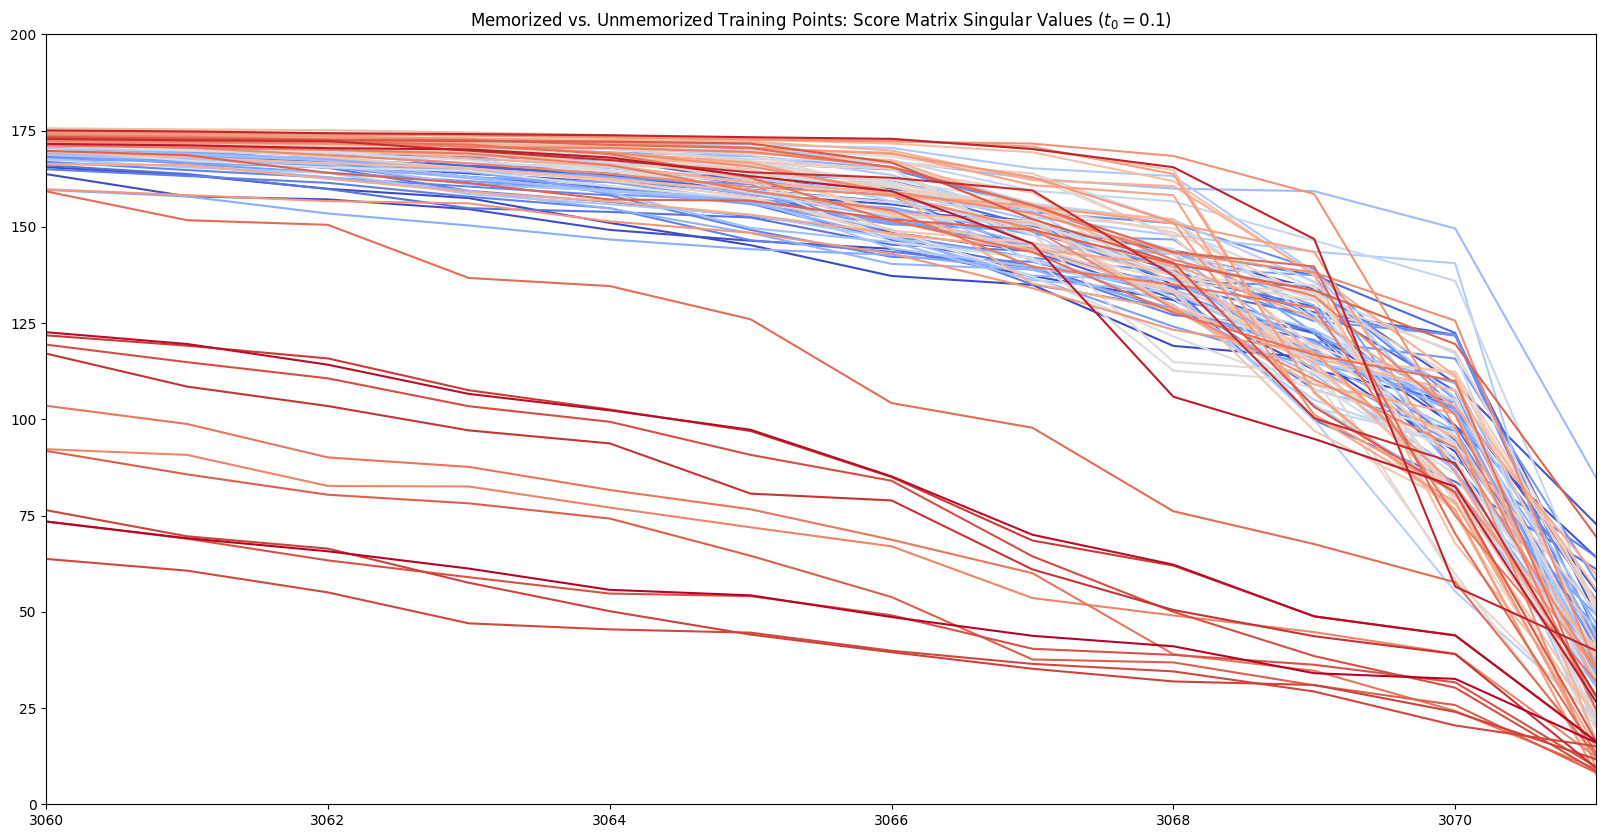

In [18]:
plot_svs(train_svs)
plt.title(f'Memorized vs. Unmemorized Training Points: Score Matrix Singular Values ($t_0 = {noise_time}$)')